In [1]:
from keras.layers import Embedding, Dense, Dropout, Input#, LSTM, Bidirectional
from keras.layers import MaxPooling1D, Conv1D, Flatten, LSTM
from keras.preprocessing import sequence#, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix as confmat,
    classification_report as creport
)

from utils import *

from gensim.test.utils import common_texts
from gensim.models import Word2Vec


np.random.seed(42)

Using TensorFlow backend.


## Language Model and Data

In [2]:
algo = 'sg' # or 'cbow'
#path = './arabic_bins/web_{}_300'.format(algo)
path = 'cc.ar.300.vec'

In [3]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(path,ext='vec')



In [4]:
# language model

# load data
data_paths = ['cl3.csv']
x_train, x_test, y_train, y_test, MAX_TEXT_LENGTH = split_datasets(data_paths, test_size=0.2, seed=42)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
# 
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, 
                                                                            y_train, y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Dataset splited.
Label categories: ['0' '1' '2' '3' '4']
Converting data to trainable form...
Number of training examples: 1200
Number of testing examples: 300


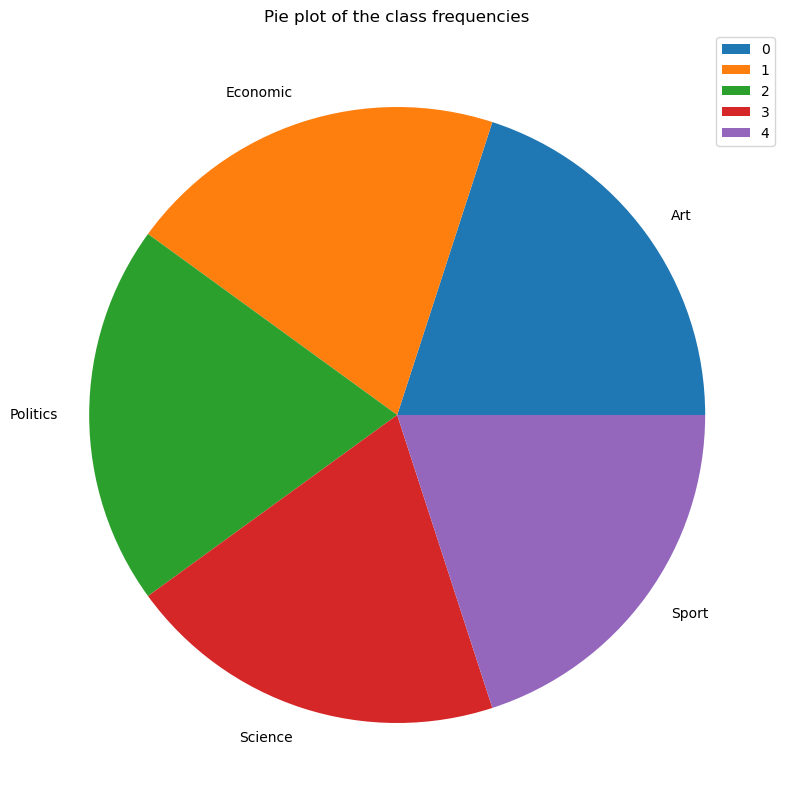

In [5]:
LABELS = (
    'Art', 'Economic', 'Politics', 'Science', 'Sport'
)

tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS)
plt.legend(unique)
#plt.savefig("./img/stats_classes.png")
plt.show();

**Try less timesteps**

In [6]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 880

Original sequence length : 880


In [7]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    
    """
    DOC
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = LSTM(units=32, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
    
    model = LSTM(units=16, return_sequences=True, return_state=False)(model)
    model = Dropout(0.1)(model)
        
    model = Flatten()(model)
        
    model = Dense(200, activation='relu')(model)
    model = Dropout(0.1)(model)
    
    model = Dense(5, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    """
    DOC
    """
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    """
    DOC 
    """
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test))#,
                        #callbacks=[TestCallback((x_test, y_test))])
    return history, model

In [8]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 880)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 880, 300)          14497500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 880, 32)           42624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 880, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 880, 16)           3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 880, 16)           0         
_________________________________________________________________
flatte

In [9]:
#del WORD_MODEL
#del word_index

## Start Learning

In [64]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y,
                               batch_size=200, epochs=10)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 [==============================] - 120s 100ms/step - loss: 0.7411 - accuracy: 0.7050 - val_loss: 0.6785 - val_accuracy: 0.7767
Epoch 2/10
1200/1200 [==============================] - 118s 99ms/step - loss: 0.7586 - accuracy: 0.7050 - val_loss: 0.7452 - val_accuracy: 0.7400
Epoch 3/10
1200/1200 [==============================] - 124s 103ms/step - loss: 0.7650 - accuracy: 0.6975 - val_loss: 0.6838 - val_accuracy: 0.7700
Epoch 4/10
1200/1200 [==============================] - 120s 100ms/step - loss: 0.7261 - accuracy: 0.7208 - val_loss: 0.7094 - val_accuracy: 0.7067
Epoch 5/10
1200/1200 [==============================] - 124s 103ms/step - loss: 1.0155 - accuracy: 0.5942 - val_loss: 0.8896 - val_accuracy: 0.6733
Epoch 6/10
1200/1200 [==============================] - 196s 163ms/step - loss: 0.7923 - accuracy: 0.7175 - val_loss: 0.6896 - val_accuracy: 0.7867
Epoch 7/10
1200/1200 [==============================] - 134s 111ms

In [65]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [66]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

300/300 [==============================] - 14s 45ms/step


[0.5951032042503357, 0.8133333325386047]

In [67]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)
# y_pred = np_utils.to_categorical(np.argmax(y_pred, axis=1), len(CLASSES_LIST))

cm = confmat(np.argmax(test_cat_y, axis=1), y_pred)

print("Confusion Matrix :\n\n {}\n".format(cm))
print(creport(np.argmax(test_cat_y, axis=1), y_pred))


Confusion Matrix :

 [[36  3 14  3  0]
 [ 2 52  7  3  1]
 [ 4  9 31  2  3]
 [ 1  0  1 64  0]
 [ 1  1  1  0 61]]

              precision    recall  f1-score   support

           0       0.82      0.64      0.72        56
           1       0.80      0.80      0.80        65
           2       0.57      0.63      0.60        49
           3       0.89      0.97      0.93        66
           4       0.94      0.95      0.95        64

    accuracy                           0.81       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.82      0.81      0.81       300



**Early Stopping**

In [68]:
import numpy as np
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 9
Accuracy on train : 74.67 %
Accuracy on test : 81.33 %
Loss on train : 64.46
Loss on test : 59.51


In [69]:
"""
LSTM simple (une seule couche, ne dépasse pas  :

Accuracy on train : 95.36 %
Accuracy on test : 94.61 %
Loss on train : 14.54
Loss on test : 17.18
""";

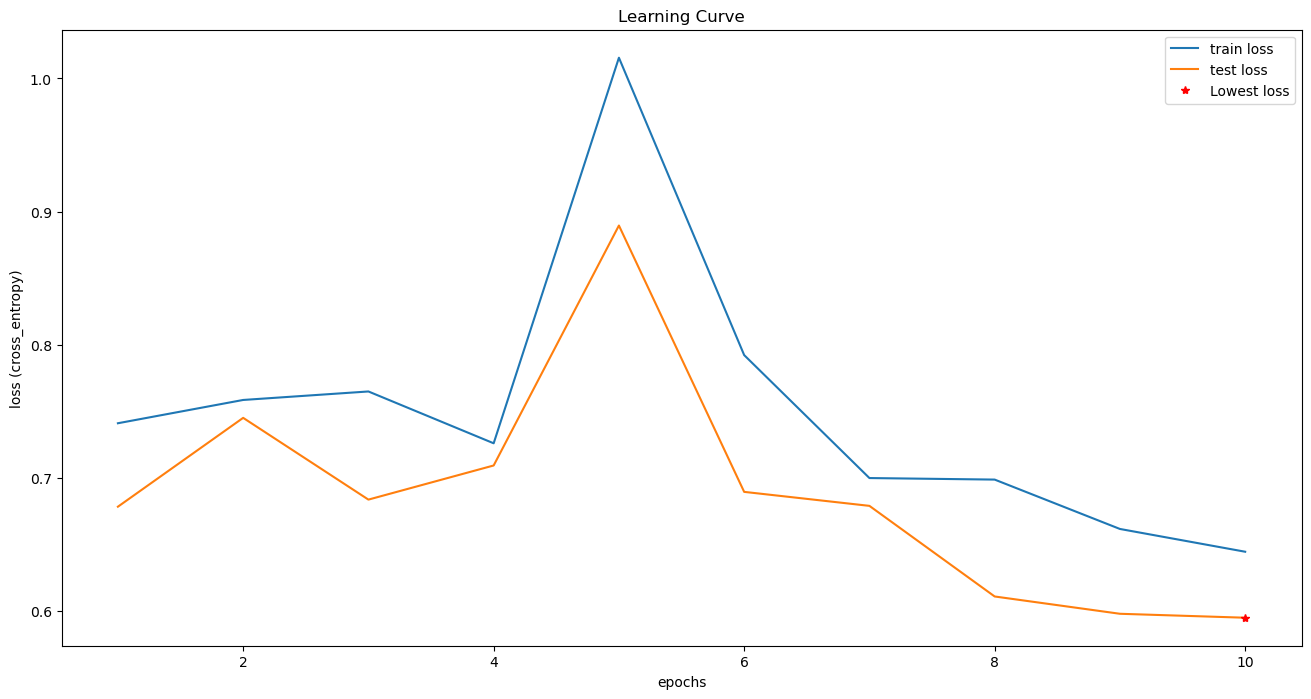

In [70]:
plt.figure("Loss Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="test loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.savefig("RNN_loss_500_2000_sg_false_150.png")
plt.show();

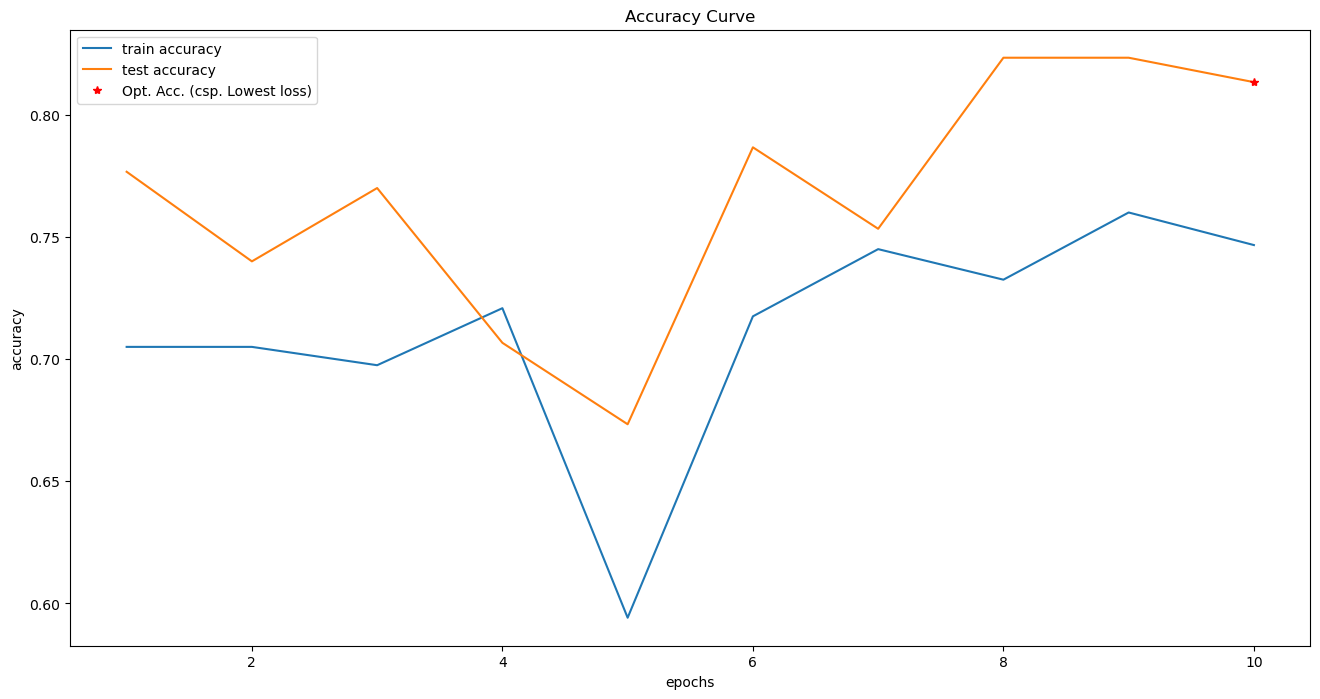

In [71]:
plt.figure("Accuracy Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="test accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.savefig("RNN_acc_500_2000_sg_false_150.png")
plt.show()

## Save results

In [72]:
import shelve

tmp = shelve.open('lstm_results')
tmp['history'] = history.history
tmp.close()

## Recompute results